<a href="https://www.kaggle.com/jaimemorillo/genre-prediction-with-distilbert?scriptVersionId=86466581" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Multi-label text classification with Naive Bayes and DistilBERT

We predict the genres of a movie from its summary (overview).

- First: Applying a classical Naive Bayes, cleaning (normalization, stop-words and stemming) and transforming the text with TF-IDF.
- Second: Applying DistilBERT on raw and tokenized text.

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tqdm.notebook import tqdm
tqdm.pandas()

# Preprocessing

Load the data

In [2]:
tmdb_df = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv', index_col='id')

Select overview and genre column

In [3]:
tmdb_df = tmdb_df.loc[:,['overview','genres']]
tmdb_df = tmdb_df.dropna(subset=['overview', 'genres'])

Take a look to our data

In [4]:
tmdb_df.head(5)

,overview,genres
id,,
19995,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
285,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""..."
206647,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
49026,Following the death of District Attorney Harve...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam..."
49529,"John Carter is a war-weary, former military ca...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."


Transform genre dict to a simple list

In [5]:
def parse_genres(genres_string):
    genres_dict = eval(genres_string)
    genres = [i['name'] for i in genres_dict]
    return genres

tmdb_df['genres'] = tmdb_df['genres'].progress_apply(lambda x: parse_genres(x))

df = tmdb_df.copy()
df.head(5)

  0%|          | 0/4800 [00:00<?, ?it/s]

,overview,genres
id,,
19995,"In the 22nd century, a paraplegic Marine is di...","[Action, Adventure, Fantasy, Science Fiction]"
285,"Captain Barbossa, long believed to be dead, ha...","[Adventure, Fantasy, Action]"
206647,A cryptic message from Bond’s past sends him o...,"[Action, Adventure, Crime]"
49026,Following the death of District Attorney Harve...,"[Action, Crime, Drama, Thriller]"
49529,"John Carter is a war-weary, former military ca...","[Action, Adventure, Science Fiction]"


Create binary targets with multilabel binarizer

In [6]:
# Multilabel Binarizer
mlb = MultiLabelBinarizer()
genres_binary = mlb.fit_transform(df['genres'])
genres = pd.DataFrame(genres_binary, columns=mlb.classes_, index=df.index)

# Remove genres with low representation
df = df.join(genres).drop(['genres', 'Foreign', 'History', 'Music', 'Animation',
                           'War', 'Western', 'TV Movie', 'Documentary'], axis=1)
df = df[df.sum(axis=1)!=0] # Remove movies with no genres

# Remove multiple white spaces in overview
df['overview'] = df['overview'].progress_apply(lambda x: re.sub(' +', ' ', x))
df.reset_index(inplace=True, drop=True)

df.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':


  0%|          | 0/4660 [00:00<?, ?it/s]

,overview,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
0,"In the 22nd century, a paraplegic Marine is di...",1,1,0,0,0,0,1,0,0,0,1,0
1,"Captain Barbossa, long believed to be dead, ha...",1,1,0,0,0,0,1,0,0,0,0,0
2,A cryptic message from Bond’s past sends him o...,1,1,0,1,0,0,0,0,0,0,0,0
3,Following the death of District Attorney Harve...,1,0,0,1,1,0,0,0,0,0,0,1
4,"John Carter is a war-weary, former military ca...",1,1,0,0,0,0,0,0,0,0,1,0


# Charts of the dataset

## Genres distribution

(4660, 13)


Text(0, 0.5, 'Genres')

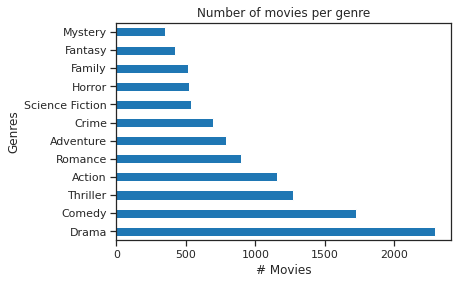

In [7]:
print(df.shape)
ax = df.iloc[:,1:].sum().sort_values(ascending=False).plot(kind='barh',
                                                           title='Number of movies per genre')
ax.set_xlabel("# Movies")
ax.set_ylabel("Genres")

### Number of genres per movie

count    4660.00
mean        2.40
std         1.06
min         1.00
25%         2.00
50%         2.00
75%         3.00
max         7.00
dtype: float64


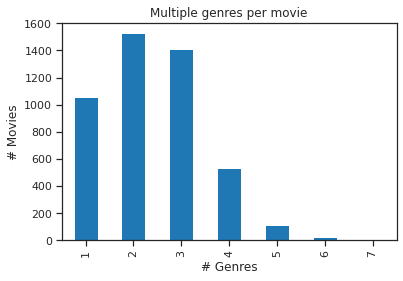

In [8]:
sum_df = df.iloc[:,1:].sum(axis=1)
ax = sum_df.value_counts().sort_index().plot(kind='bar', title='Multiple genres per movie')
ax.set_xlabel('# Genres')
ax.set_ylabel('# Movies')
print(sum_df.describe().round(2))

### Number of characters

count    4660.0
mean      304.1
std       159.9
min         1.0
25%       178.0
50%       284.0
75%       391.0
max      1000.0
Name: overview, dtype: float64


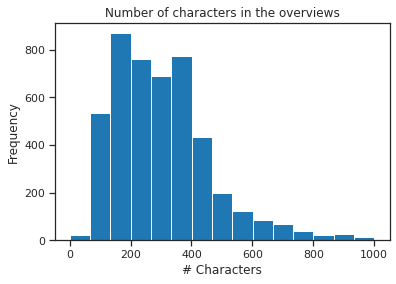

In [9]:
chr_lens = df.overview.str.len()
ax = chr_lens.plot(kind='hist', bins=15, title='Number of characters in the overviews')
ax.set_xlabel("# Characters")
print(chr_lens.describe().round(2))

### Number of words

count    4660.00
mean       51.99
std        27.44
min         2.00
25%        30.00
50%        48.00
75%        67.00
max       175.00
Name: overview, dtype: float64


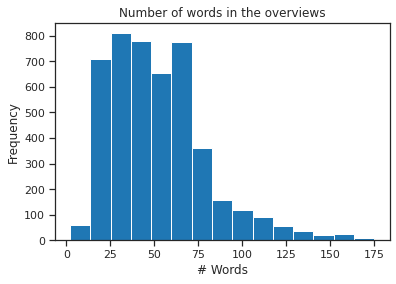

In [10]:
word_lens = df.overview.str.split(" ").str.len()
ax = word_lens.plot(kind='hist', bins=15, title='Number of words in the overviews')
ax.set_xlabel("# Words")
print(word_lens.describe().round(2))

In [11]:
df_final = df.copy()
df_final.shape

(4660, 13)

# Naive Bayes

In [ ]:
stop_words = set(stopwords.words('english')) # Stop words
porter = PorterStemmer() # Stemmer

def clean(text):
    text = text.lower() # To lower case
    # Replace contractions
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text) # Replace any character which is not a word character
    text = re.sub('\s+', ' ', text) # Replace any whitespace character
    text = re.sub(' +', ' ', text) # Replace multiple whitespaces
    text = text.strip() # Delete sorrounding whitespaces
    tokens = word_tokenize(text) # Tokenize text
    #  Delete Stop Words and apply stemming
    new_tokens = [porter.stem(word) for word in tokens if not word in stop_words] 
    text = (" ").join(new_tokens) # Join tokens
    return text

df_final['overview'] = df_final['overview'].progress_apply(lambda x: clean(x))

In [ ]:
print('Og: ' + df['overview'][5])
print('New: ' + df_final['overview'][5])

In [ ]:
X = df_final.overview
y = df_final.drop(['overview'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
print(X_train.shape)
print(X_test.shape)

Tf-Idf strategy

In [ ]:
# Ignore words that appear in less than 10 document and more than 80% of the documents
tfidf = TfidfVectorizer(stop_words=stop_words, max_df=0.8, min_df=10)
X_train_enc = tfidf.fit_transform(X_train)
X_test_enc = tfidf.transform(X_test)

print('Vocabulary: ' + str(X_train_enc.shape[1]))
print('Og: ' + X_train[3])
print('Encoded: ' + str(X_train_enc[3]))

Naive Bayes (One vs Rest / Multilabel)

In [ ]:
clf = OneVsRestClassifier(MultinomialNB())
clf.fit(X_train_enc, y_train)
y_pred_proba = clf.predict_proba(X_test_enc)
predictions = clf.predict(X_test_enc)

### Metrics

In [ ]:
metrics = ['Ranking Average Precision', 'Ranking Loss', 'Exact Match Ratio', 'Recall', 'Precision', 'F1-Score']
results = pd.DataFrame(index=metrics)
results.index.name = 'Metrics'
results['Naive Bayes'] = 0
results['DistilBERT'] = 0

In [ ]:
results.loc['Ranking Average Precision', 'Naive Bayes'] = sklearn.metrics.label_ranking_average_precision_score(y_test, y_pred_proba)
results.loc['Ranking Loss', 'Naive Bayes'] = sklearn.metrics.label_ranking_loss(y_test, y_pred_proba)
results.loc['Exact Match Ratio', 'Naive Bayes'] = sklearn.metrics.accuracy_score(y_test, predictions)
results.loc['Recall', 'Naive Bayes'] = sklearn.metrics.precision_score(y_test, y_pred=predictions, average='samples')
results.loc['Precision', 'Naive Bayes'] = sklearn.metrics.recall_score(y_test, y_pred=predictions, average='samples')
results.loc['F1-Score', 'Naive Bayes'] = sklearn.metrics.f1_score(y_test, y_pred=predictions, average='samples')
results = results.round(2)
print(results)

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(14, 10), sharey=True, sharex=True)
fig.suptitle('Confusion Matrixes - Naive Bayes', fontsize=16)

confusion_matrixes = sklearn.metrics.multilabel_confusion_matrix(y_test, predictions)
for idx,i in enumerate(confusion_matrixes):
    f1_score = sklearn.metrics.f1_score(y_test.iloc[:,idx], pd.DataFrame(predictions).iloc[:,idx])
    f1_score = round(f1_score,2)
    ax = axes.flat[idx]
    vmax = i[1,0] + i[1,1]
    sns.heatmap(i, annot=True, fmt='g', vmin=0, vmax=vmax, cmap="Blues", cbar=False,
                ax=ax).set_title(y_test.columns[idx] + ' (F1-score: ' + str(f1_score) + ')')

# Set common labels
fig.text(0.5, 0.06, 'Prediction', ha='center', va='center')
fig.text(0.08, 0.5, 'Real value', ha='center', va='center', rotation='vertical')

# DistilBERT

In [ ]:
X = df.overview
y = df.drop(['overview'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Example

In [ ]:
text = X_train.iloc[0]
encoded_input = tokenizer(text)

print('Original text: '+ text)
print('Tokens: ' + str(encoded_input))
print('Reverse tokens: ' + tokenizer.decode(encoded_input["input_ids"]))

In [ ]:
batch_sentences = X_train.values.tolist()
X_train = tokenizer(batch_sentences, padding=True, 
                    truncation=True, return_tensors="tf")
X_train['targets'] = np.array(y_train)
max_length = X_train['input_ids'].shape[1]

batch_sentences = X_test.values.tolist()
X_test = tokenizer(batch_sentences, padding='max_length', max_length=max_length, 
                   truncation=True, return_tensors="tf")
X_test['targets'] = np.array(y_test)

print(X_train)
print(tokenizer.decode(X_train["input_ids"][0]))

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                              num_labels=len(y_train.columns), 
                                                              problem_type="multi_label_classification")

In [ ]:
train_features = {x: X_train[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, X_train["targets"]))
train_tf_dataset = train_tf_dataset.shuffle(len(X_train)).batch(32)

test_features = {x: X_test[x] for x in tokenizer.model_input_names}
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_features, X_test["targets"]))
test_tf_dataset = test_tf_dataset.batch(32)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.BinaryAccuracy()
)

model.fit(train_tf_dataset, validation_data=test_tf_dataset, epochs=3)

Logits to labels 
https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow

Probability of 0.5 corresponds to a logit of 0. Negative logit correspond to probabilities less than 0.5, positive to > 0.5.

In [ ]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

y_pred_logits = model.predict(test_tf_dataset)
y_pred_proba = inv_logit(y_pred_logits[0])

predictions = pd.DataFrame(y_pred_proba, columns=y_test.columns, index=y_test.index).copy()
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0

### Metrics

https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

https://stackoverflow.com/questions/31311154/explanation-for-coverage-error-metric-in-scikit-learn

https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics

In [ ]:
results.loc['Ranking Average Precision', 'DistilBERT'] = sklearn.metrics.label_ranking_average_precision_score(y_test, y_pred_proba)
results.loc['Ranking Loss', 'DistilBERT'] = sklearn.metrics.label_ranking_loss(y_test, y_pred_proba)
results.loc['Exact Match Ratio', 'DistilBERT'] = sklearn.metrics.accuracy_score(y_test, predictions)
results.loc['Recall', 'DistilBERT'] = sklearn.metrics.precision_score(y_test, y_pred=predictions, average='samples')
results.loc['Precision', 'DistilBERT'] = sklearn.metrics.recall_score(y_test, y_pred=predictions, average='samples')
results.loc['F1-Score', 'DistilBERT'] = sklearn.metrics.f1_score(y_test, y_pred=predictions, average='samples')
results = results.round(2)
print(results)

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(14, 10), sharey=True, sharex=True)
fig.suptitle('Confusion Matrixes - DistilBERT', fontsize=16)

confusion_matrixes = sklearn.metrics.multilabel_confusion_matrix(y_test, predictions)
for idx,i in enumerate(confusion_matrixes):
    f1_score = sklearn.metrics.f1_score(y_test.iloc[:,idx], predictions.iloc[:,idx])
    f1_score = round(f1_score,2)
    ax = axes.flat[idx]
    vmax = i[1,0] + i[1,1]
    sns.heatmap(i, annot=True, fmt='g', vmin=0, vmax=vmax, cmap="Blues", cbar=False,
                ax=ax).set_title(y_test.columns[idx] + ' (F1-score: ' + str(f1_score) + ')')

# Set common labels
fig.text(0.5, 0.06, 'Prediction', ha='center', va='center')
fig.text(0.08, 0.5, 'Real value', ha='center', va='center', rotation='vertical')